In [1]:
from pathlib import Path
import os, sys
from rasterstats import zonal_stats
import rasterio as rio
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import SymLogNorm

In [2]:
project_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_path)
from config import Config
from metric_comp import MetricDataset, resample_raster, create_summary_stats
config = Config()
len(config.modis_metric_names) == len(config.viirs_metric_names)

True

Create dictionary to hold arrays from MODIS and VIIRS metric bands

In [3]:
year = 2015
compare_metrics_dict = {}
for i in range(0, len(config.modis_metric_names)):
    compare_metrics_dict[f"{year} Band {i + 1}"] = {}
compare_metrics_dict

{'2015 Band 1': {},
 '2015 Band 2': {},
 '2015 Band 3': {},
 '2015 Band 4': {},
 '2015 Band 5': {},
 '2015 Band 6': {},
 '2015 Band 7': {},
 '2015 Band 8': {},
 '2015 Band 9': {},
 '2015 Band 10': {},
 '2015 Band 11': {},
 '2015 Band 12': {}}

Access MODIS and VIIRS metrics bands and add to array

In [4]:
for i in range(0, len(config.modis_metric_names)):
    print(f"Loading MODIS metric {i + 1}: {config.modis_metric_names[i]}")
    mds = MetricDataset(config.split_modis_metric_path, i+1, year, 'modis', 'new-6', config.modis_metric_names)
    mds_array, mds_transform = mds.load_tiff()
    compare_metrics_dict[f"{year} Band {i + 1}"]["modis"] = mds_array

Loading MODIS metric 1: first_snow_day
Loading MODIS metric 2: last_snow_day
Loading MODIS metric 3: fss_range
Loading MODIS metric 4: longest_css_first_day
Loading MODIS metric 5: longest_css_last_day
Loading MODIS metric 6: longest_css_day_range
Loading MODIS metric 7: snow_days
Loading MODIS metric 8: no_snow_days
Loading MODIS metric 9: css_segment_num
Loading MODIS metric 10: mflag
Loading MODIS metric 11: cloud_days
Loading MODIS metric 12: tot_css_days


In [5]:
if mds:
    for i in range(0, len(config.modis_metric_names)):
        if config.viirs_metric_names[i] is None:
            continue
        print(f"Loading VIIRS metric {i + 1}: {config.viirs_metric_names[i]}")
        vds = MetricDataset(config.viirs_metric_path, i+1, year, 'viirs', 'v1', config.viirs_metric_names)
        vds_array, vds_transform = resample_raster(mds, vds) #Use resample_raster to warp viirs metrics to modis grid
        compare_metrics_dict[f"{year} Band {i + 1}"]["viirs"] = vds_array

Loading VIIRS metric 1: first_snow_day
Loading VIIRS metric 2: last_snow_day
Loading VIIRS metric 3: fss_range
Loading VIIRS metric 4: longest_css_start
Loading VIIRS metric 5: longest_css_end
Loading VIIRS metric 6: longest_css_range
Loading VIIRS metric 7: snow_days
Loading VIIRS metric 8: no_snow_days
Loading VIIRS metric 9: css_segment_num
Loading VIIRS metric 12: tot_css_days


-349.0 -12.846460994496255 309.0 (4391, 7036)


-317.0 12.036459031841213 358.0 (4391, 7036)


-365.0 24.88292002633747 364.0 (4391, 7036)


-349.0 -107.77415358668274 236.0 (4391, 7036)


-221.0 32.282482837869225 338.0 (4391, 7036)


-176.0 140.05663642455198 350.0 (4391, 7036)


-211.0 72.28107348559402 364.0 (4391, 7036)


-359.0 -66.74551355490873 211.0 (4391, 7036)


-11.0 -1.4899290239765963 5.0 (4391, 7036)


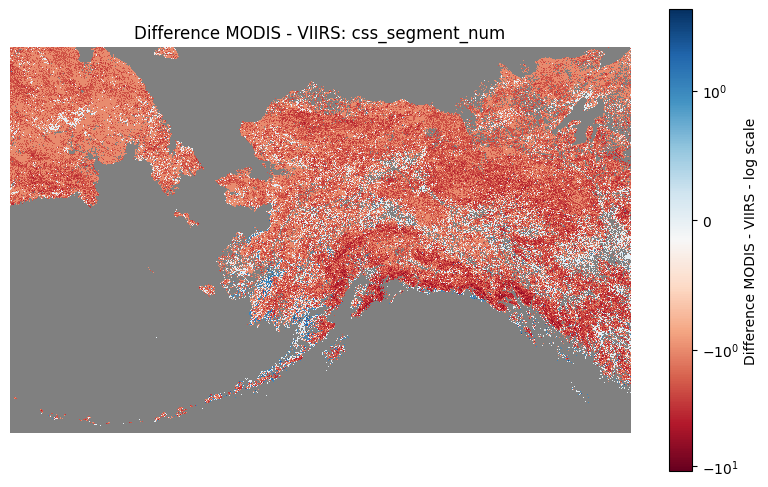

-196.0 90.88619614013844 351.0 (4391, 7036)


In [62]:
for i in range(0, len(config.modis_metric_names)):
    d = compare_metrics_dict[f'2015 Band {i+1}']
    if 'viirs' in d.keys():
        modis_array = np.where(d['modis']==0, np.nan, d['modis'])
        viirs_array = np.where(d['viirs']==0, np.nan, d['viirs'])
        dif = modis_array - viirs_array
        
        dif = np.ma.masked_where(np.isnan(dif), dif)
        print(dif.min(), dif.mean(), dif.max(), dif.shape)

        # Plot the difference raster
        plt.figure(figsize=(10, 6))

        cmap = plt.get_cmap('RdBu')
        cmap.set_bad(color='gray')

        # Use SymLogNorm for symmetric logarithmic scaling
        symlog_norm = SymLogNorm(linthresh=1, vmin=dif.min(), vmax=dif.max(), base=10)
        # Use TwoSlopeNorm to center the colormap at zero
        #divnorm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10)#vmin=difference.min(), vcenter=0, vmax=difference.max())

        # Plot using a diverging colormap (e.g., 'RdBu' or 'PiYG')
        plt.imshow(dif, cmap=cmap, norm=symlog_norm, interpolation='nearest')

        # Add colorbar
        plt.colorbar(label='Difference MODIS - VIIRS - log scale')

        # Add title and labels
        plt.title(f'Difference MODIS - VIIRS: {config.modis_metric_names[i]}')
        #plt.xlabel('X')
        #plt.ylabel('Y')
        plt.axis('off')

        # Show the plot
        plt.show()

-349.0 -12.846460994496255 309.0 (4391, 7036)


-317.0 12.036459031841213 358.0 (4391, 7036)


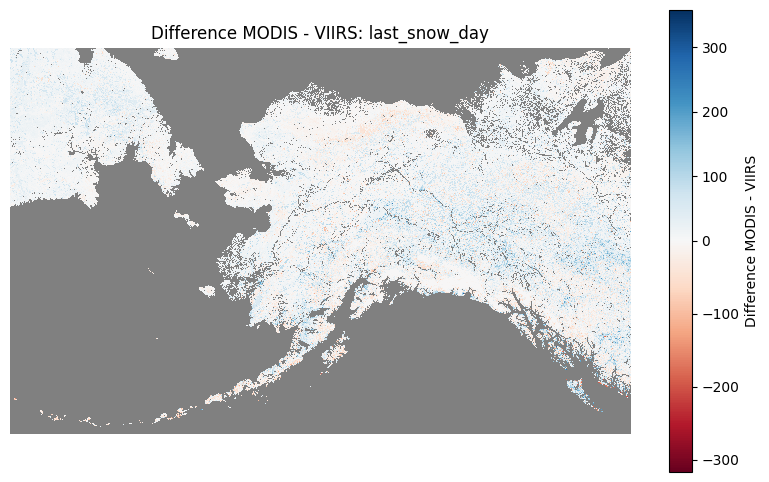

-365.0 24.88292002633747 364.0 (4391, 7036)


-349.0 -107.77415358668274 236.0 (4391, 7036)


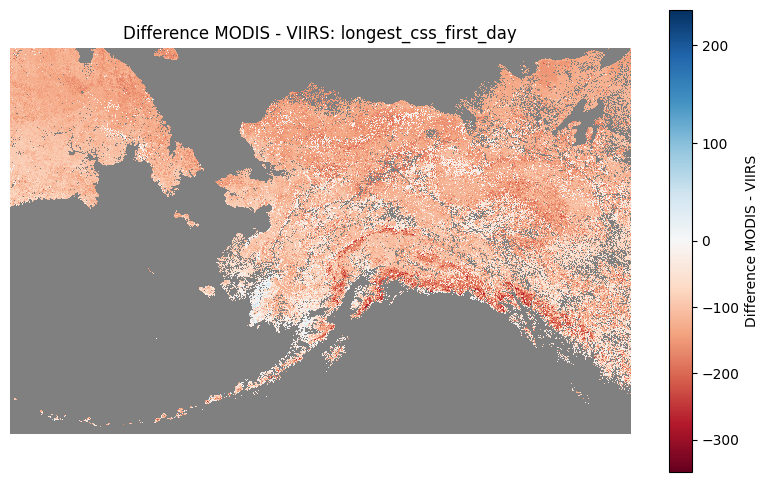

-221.0 32.282482837869225 338.0 (4391, 7036)


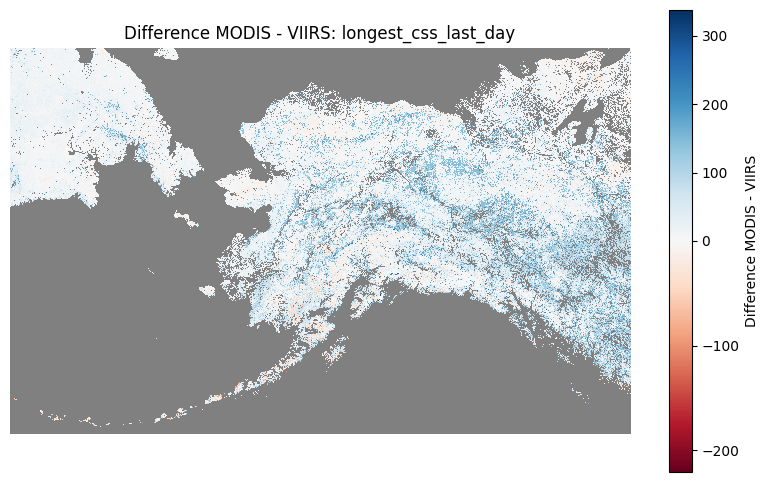

-176.0 140.05663642455198 350.0 (4391, 7036)


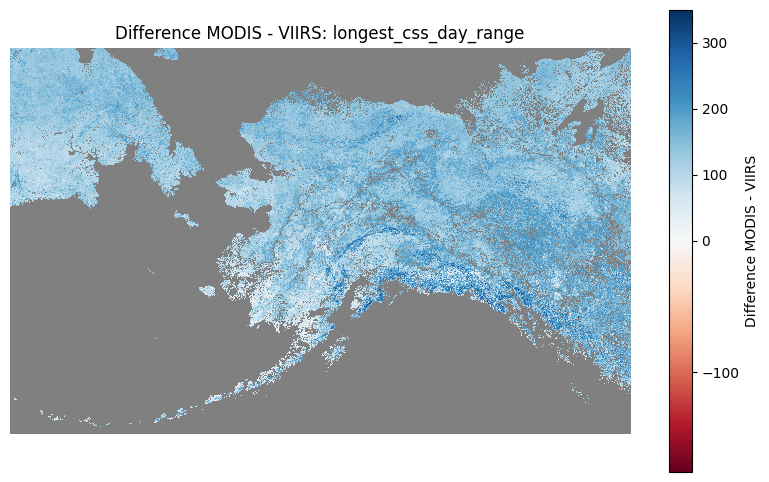

-211.0 72.28107348559402 364.0 (4391, 7036)


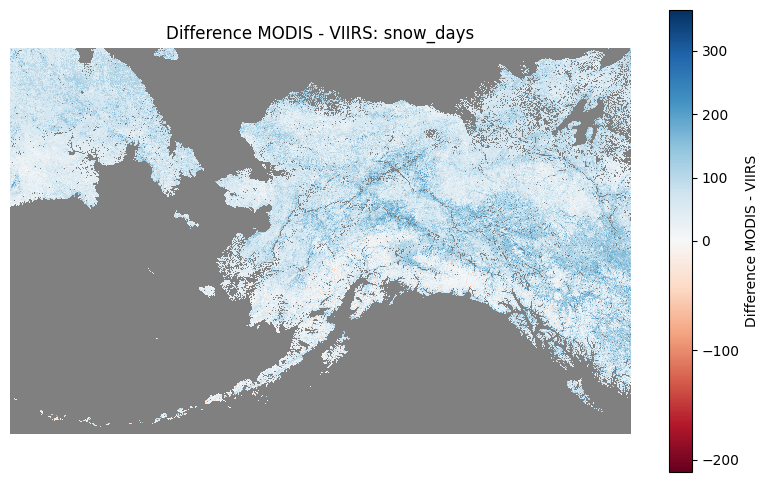

-359.0 -66.74551355490873 211.0 (4391, 7036)


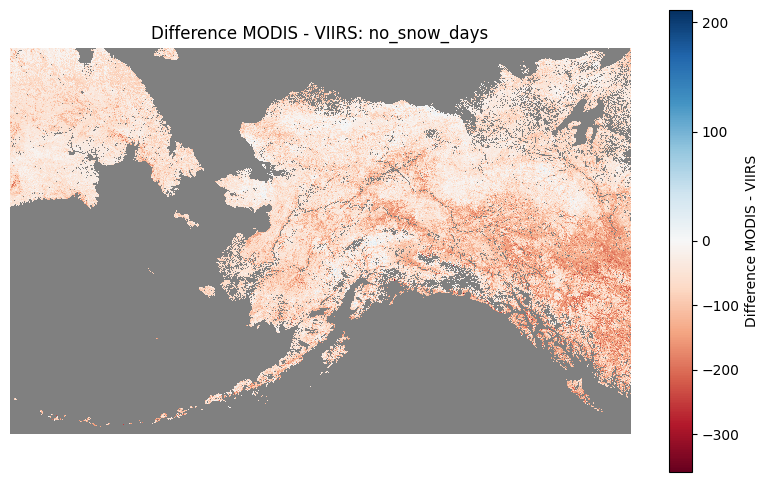

-11.0 -1.4899290239765963 5.0 (4391, 7036)


-196.0 90.88619614013844 351.0 (4391, 7036)


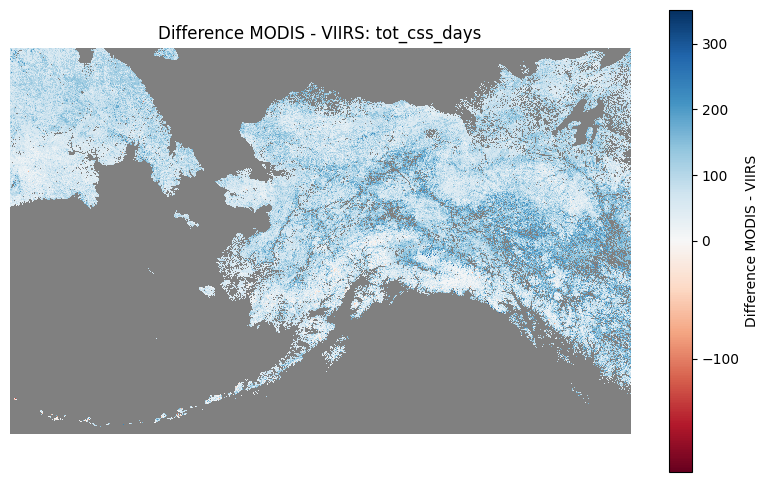

In [65]:
for i in range(0, len(config.modis_metric_names)):
    d = compare_metrics_dict[f'2015 Band {i+1}']
    if 'viirs' in d.keys():
        modis_array = np.where(d['modis']==0, np.nan, d['modis'])
        viirs_array = np.where(d['viirs']==0, np.nan, d['viirs'])
        dif = modis_array - viirs_array
        
        dif = np.ma.masked_where(np.isnan(dif), dif)
        print(dif.min(), dif.mean(), dif.max(), dif.shape)

        # Plot the difference raster
        plt.figure(figsize=(10, 6))

        cmap = plt.get_cmap('RdBu')
        cmap.set_bad(color='gray')

        # Use SymLogNorm for symmetric logarithmic scaling
        #symlog_norm = SymLogNorm(linthresh=1, vmin=dif.min(), vmax=dif.max(), base=10)
        # Use TwoSlopeNorm to center the colormap at zero
        divnorm = TwoSlopeNorm(vmin=dif.min(), vcenter=0, vmax=dif.max())

        # Plot using a diverging colormap (e.g., 'RdBu' or 'PiYG')
        plt.imshow(dif, cmap=cmap, norm=divnorm, interpolation='nearest')

        # Add colorbar
        plt.colorbar(label='Difference MODIS - VIIRS')

        # Add title and labels
        plt.title(f'Difference MODIS - VIIRS: {config.modis_metric_names[i]}')
        #plt.xlabel('X')
        #plt.ylabel('Y')
        plt.axis('off')

        # Show the plot
        plt.show()

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot only the histogram for the first item in the dictionary
for i, (key, values) in enumerate(compare_metrics_dict.items()):
    if i == 0:
        try:
            viirs_metric = values['viirs']
        except:
            continue
        modis_metric = values['modis']

        diff_metric = modis_metric - viirs_metric
        
        # Remove Zeros 
        diff_z_mask = np.nonzero(diff_metric)
        diff_metric = diff_metric[diff_z_mask]

        # Calculate the histograms
        diff_hist, diff_bins = np.histogram(diff_metric, bins=40)

        # Plot the histograms
        ax.hist(diff_metric.flatten(), bins=diff_bins, alpha=1, label='modis - viirs')


        # Set title and labels for each subplot
        ax.set_title(f"{year} Metric {config.modis_metric_names[i]}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        # Add a legend to the subplot
        ax.legend()

# Adjust layout for better spacing
#plt.tight_layout()
#plt.show()
#plt.savefig(Path(stats_output_dir) / f"{year}_band{j+1}_clipped_viirs_and_modis_histograms_no_zeros.png", dpi=144)
plt.show()

In [88]:
np.unique(diff_metric, return_counts=True)

(array([-549, -548, -539, ...,  571,  573,  576], dtype=int16),
 array([1, 1, 3, ..., 5, 7, 1]))

In [87]:
diff_metric.flatten().shape

(13568077,)